In [1]:
!pip install kagglehub split-folders

#Import libraries


In [2]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models, callbacks,regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from collections import Counter

#Split the data and create two folders for training and validation to prevent data leakage.

In [3]:
#dawonload the data set
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:27<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [4]:
# Path to the folder containing images
import shutil
path = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2"
dataset_dir = os.path.join(path, "raw-img")  # Ensure this folder name is correct

# New output directory for split data
output_dir = os.path.join(path, "Animals10_Split")
# Delete existing split folders if they exist
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)


In [5]:

# Split the dataset into 80% training and 20% validation
splitfolders.ratio(
    dataset_dir,
    output=output_dir,
    seed=42,
    ratio=(0.8, 0.2),  # 80% training, 20% validation
    group_prefix=None,
    move=False  # Set to True if you want to move files instead of copying
)

# Define the new paths
train_dir = os.path.join(output_dir, "train")
valid_dir = os.path.join(output_dir, "val")

print("Training Data Path:", train_dir)
print("Validation Data Path:", valid_dir)

Copying files: 26179 files [00:03, 6935.37 files/s]

Training Data Path: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/Animals10_Split/train
Validation Data Path: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/Animals10_Split/val


#Data Preprocessing and Augmentation


In [6]:

# Image augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=10,  # Mild rotation
    zoom_range=0.05,  # Small zoom
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,  # Keep horizontal flips
    fill_mode="nearest"
)


valid_datagen = ImageDataGenerator(rescale=1/255.0)  # No augmentation for validation


# Load training data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,  # Path to training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42
)

# Load validation data
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,  # Path to validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42
)
# Check class distribution in training set
train_classes = train_generator.classes
print("Training class distribution:", Counter(train_classes))

# Check class distribution in validation set
valid_classes = valid_generator.classes
print("Validation class distribution:", Counter(valid_classes))


Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.
Training class distribution: Counter({0: 3890, 8: 3856, 4: 2478, 1: 2098, 3: 1689, 6: 1492, 9: 1489, 7: 1456, 5: 1334, 2: 1156})
Validation class distribution: Counter({0: 973, 8: 965, 4: 620, 1: 525, 3: 423, 6: 374, 9: 373, 7: 364, 5: 334, 2: 290})


#Visualizing Sample Images with Translated Class Names


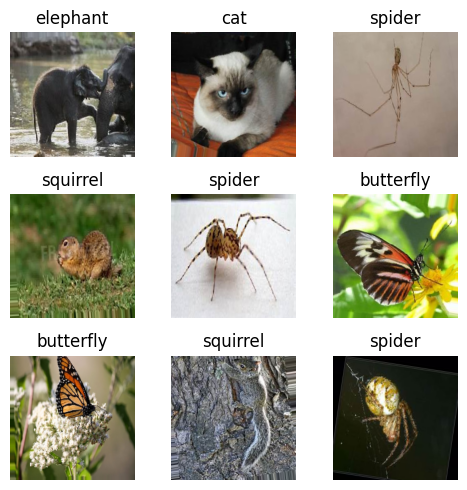

In [7]:

# Translation dictionary
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

# Define the class names in English
class_names = list(translate.values())  # ["dog", "horse", "elephant", ...]

def image(images, labels, class_names, class_indices):
    plt.figure(figsize=(5, 5))  # Create a figure with a larger size
    for i in range(9):  # Loop through 9 images
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid and select the (i+1)th subplot
        plt.imshow(images[i])  # Display the image

        # Get the Italian folder name from class_indices
        italian_name = list(class_indices.keys())[labels[i].argmax()]
        # Translate to English

        english_name = translate[italian_name]
        plt.title(english_name)  # Set the title as the English class name
        plt.axis('off')  # Hide axes
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Display the entire figure

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot images
image(images, labels, class_names, train_generator.class_indices)


In [8]:
print(class_names)

['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'squirrel', 'spider']


##bulid CNN simple model

In [9]:
# Define the CNN model
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 32 filters, 3x3 kernel
    MaxPooling2D((2, 2)),  # 2x2 pooling
    Conv2D(64, (3, 3), activation='relu'),  # 64 filters, 3x3 kernel
    MaxPooling2D((2, 2)),  # 2x2 pooling
    Conv2D(128, (3, 3), activation='relu'),  # 128 filters, 3x3 kernel
    MaxPooling2D((2, 2)),  # 2x2 pooling

    # Fully connected layers
    Flatten(),  # Flatten the feature maps
    Dense(128, activation='relu'),  # Fully connected layer with 128 units
    Dropout(0.5),  # Dropout for regularization
    Dense(10, activation='softmax')  # Output layer with 10 units (for 10 classes)
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

#train the model

In [10]:
# Add callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 233s 344ms/step - accuracy: 0.2265 - loss: 2.1693 - val_accuracy: 0.4169 - val_loss: 1.6942 - learning_rate: 0.0010
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 227s 346ms/step - accuracy: 0.4035 - loss: 1.7236 - val_accuracy: 0.5245 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 222s 340ms/step - accuracy: 0.4604 - loss: 1.5742 - val_accuracy: 0.5592 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 222s 338ms/step - accuracy: 0.5075 - loss: 1.4207 - val_accuracy: 0.5591 - val_loss: 1.2829 - learning_rate: 0.0010
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 219s 334ms/step - accuracy: 0.5438 - loss: 1.3317 - val_accuracy: 0.6012 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 219s 335ms/step - accuracy: 0.5553 - loss: 1.2772 - val_accuracy: 0.6535 - val_loss: 1.0432 - learning_rate: 0.0010
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 224s 341ms/step - accura

### Evaluate the model


In [18]:
# Evaluate the first CNN model
test_loss1, test_acc1 = model.evaluate(valid_generator)
print(f"First Model Test Accuracy: {test_acc1:.4f}")
print(f"First Model Test Loss: {test_loss1:.4f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6950 - loss: 0.9467
First Model Test Accuracy: 0.6949
First Model Test Loss: 0.9365


#Improved CNN model


In [11]:
#Improved CNN model
model2 = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes for Animals10 dataset
])

# Compile the model
model2.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,399,114 (74.00 MB)

 Trainable params: 19,398,154 (74.00 MB)

 Non-trainable params: 960 (3.75 KB)

#train

In [19]:
# Add callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
history2 = model2.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 227s 347ms/step - accuracy: 0.6620 - loss: 1.6580 - val_accuracy: 0.6411 - val_loss: 1.7763 - learning_rate: 2.0000e-04
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 224s 342ms/step - accuracy: 0.6787 - loss: 1.6014 - val_accuracy: 0.6293 - val_loss: 1.8535 - learning_rate: 2.0000e-04
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 223s 341ms/step - accuracy: 0.7015 - loss: 1.5607 - val_accuracy: 0.7094 - val_loss: 1.6023 - learning_rate: 2.0000e-04
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 220s 336ms/step - accuracy: 0.7188 - loss: 1.5351 - val_accuracy: 0.6894 - val_loss: 1.6540 - learning_rate: 2.0000e-04
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 220s 336ms/step - accuracy: 0.7298 - loss: 1.4983 - val_accuracy: 0.7046 - val_loss: 1.6219 - learning_rate: 2.0000e-04
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 221s 337ms/step - accuracy: 0.7411 - loss: 1.4968 - val_accuracy: 0.6953 - val_loss: 1.7528 - learning_rate: 2.0000e-04
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 

##Eval Improved CNN model


In [21]:
# Evaluate the second CNN model
test_loss2, test_acc2 = model2.evaluate(valid_generator)

# Print evaluation results
print(f"Improved Model Test Accuracy: {test_acc2:.4f}")
print(f"Improved Model Test Loss: {test_loss2:.4f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7292 - loss: 1.5451
Improved Model Test Accuracy: 0.7275
Improved Model Test Loss: 1.5557


### Compare results

First Model Test Accuracy: 0.6949, Test Loss: 0.9365
Improved Model Test Accuracy: 0.7275, Test Loss: 1.5557


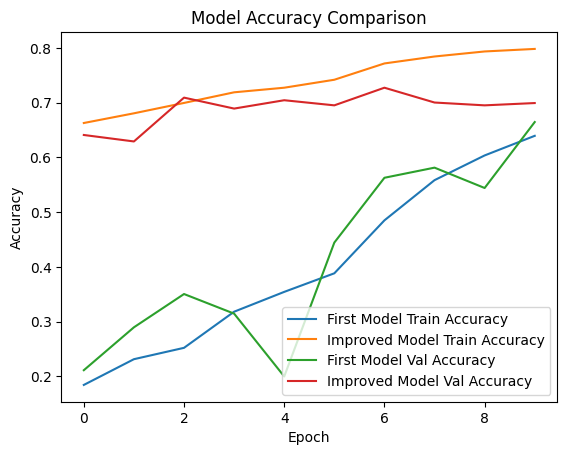

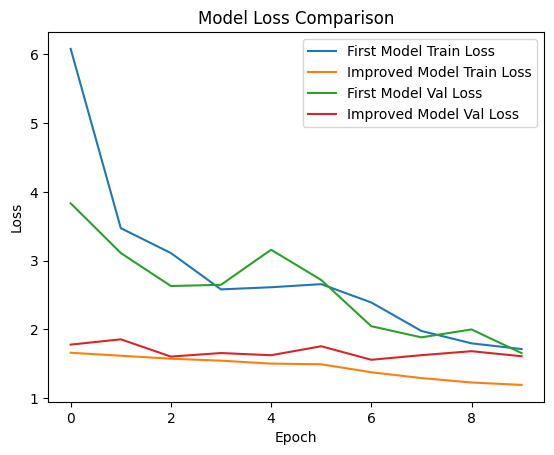

In [23]:
# Compare results
print(f"First Model Test Accuracy: {test_acc1:.4f}, Test Loss: {test_loss1:.4f}")
print(f"Improved Model Test Accuracy: {test_acc2:.4f}, Test Loss: {test_loss2:.4f}")

# Optionally, you can plot the training history of both models
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='First Model Train Accuracy')
plt.plot(history2.history['accuracy'], label='Improved Model Train Accuracy')
plt.plot(history.history['val_accuracy'], label='First Model Val Accuracy')
plt.plot(history2.history['val_accuracy'], label='Improved Model Val Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='First Model Train Loss')
plt.plot(history2.history['loss'], label='Improved Model Train Loss')
plt.plot(history.history['val_loss'], label='First Model Val Loss')
plt.plot(history2.history['val_loss'], label='Improved Model Val Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


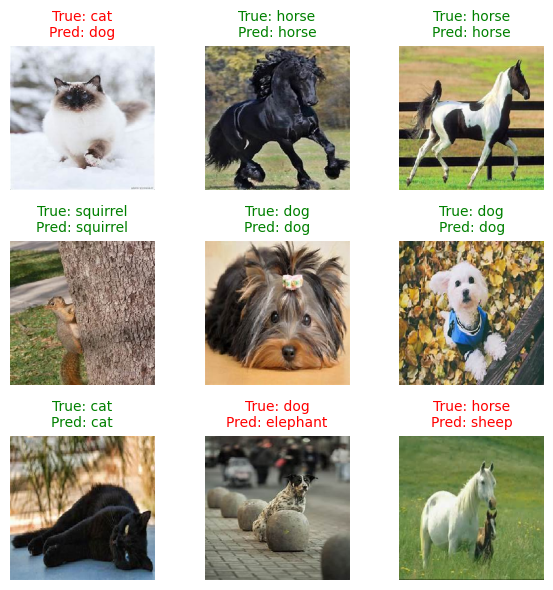

In [24]:
import numpy as np

# Function to make predictions and visualize results
def predict_and_visualize(model, generator, class_indices, translate, num_images=9):
    images, true_labels = next(generator)  # Get a batch of images
    predictions = model2.predict(images)  # Get model predictions

    plt.figure(figsize=(6, 6))  # Set figure size
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid

        plt.imshow(images[i])  # Show image
        plt.axis("off")  # Hide axes

        # Get true label
        if isinstance(true_labels[i], np.ndarray):  # If one-hot encoded
            true_class_index = np.argmax(true_labels[i])
        else:  # If labels are integers
            true_class_index = true_labels[i]

        true_italian_name = list(class_indices.keys())[true_class_index]
        true_english_name = translate[true_italian_name]

        # Get predicted label
        pred_class_index = np.argmax(predictions[i])
        pred_italian_name = list(class_indices.keys())[pred_class_index]
        pred_english_name = translate[pred_italian_name]

        # Set title with true vs predicted label
        title_color = "green" if true_english_name == pred_english_name else "red"
        plt.title(f"True: {true_english_name}\nPred: {pred_english_name}", fontsize=10, color=title_color)

    plt.tight_layout()  # Adjust spacing
    plt.show()  # Show the images

# Call the function
predict_and_visualize(model, valid_generator, train_generator.class_indices, translate)
